# Notebook 02: Positional Gravity & Territorial Analysis

## Purpose
The goal of this notebook is to visualize the **territorial dominance** of both Spain and England during the Euro 2024 Final. We use **Heatmaps (KDE Plots)** to identify where each team spent most of their time and where their passing sequences were most concentrated.

## Tactical Concepts
* **Territorial Gravity:** Areas with higher color intensity indicate where the team had the most ball control.
* **Comparison:** Comparing the two heatmaps side-by-side reveals the tactical battle between Spain's high-line dominance and England's defensive shape.

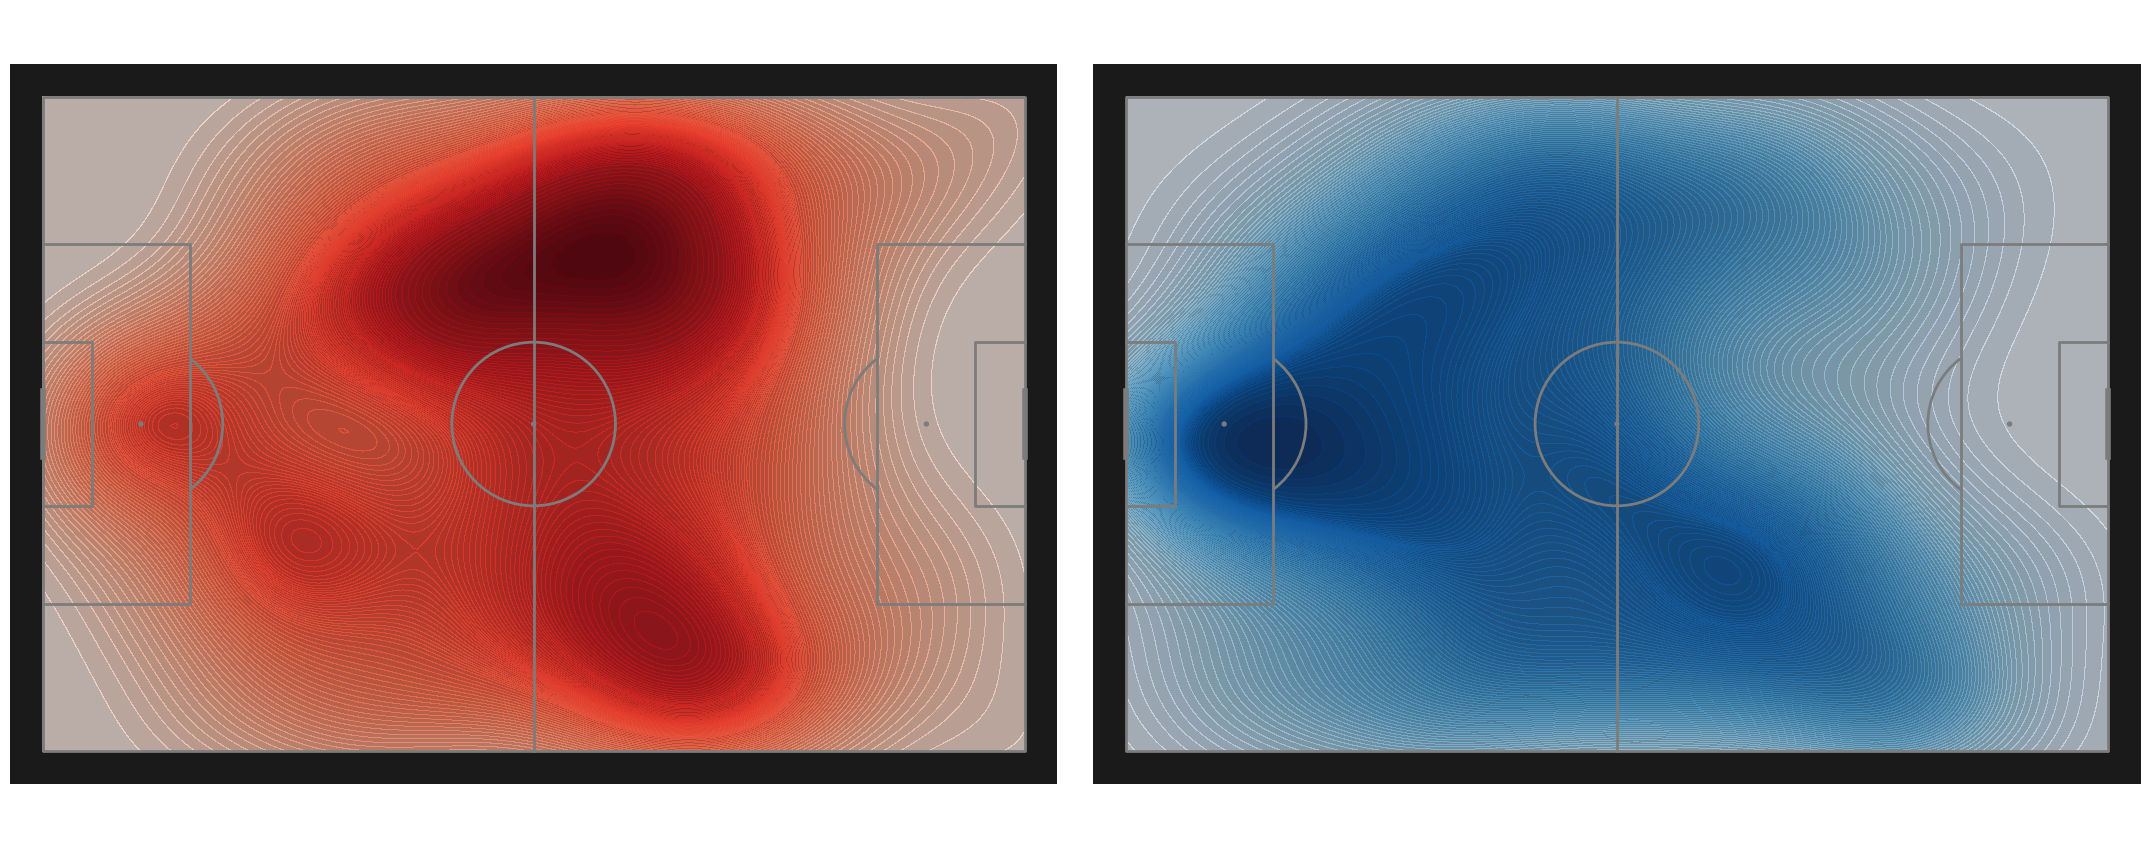

In [1]:
import pandas as pd
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import os

# 1. Load data
events = pd.read_csv('data/euro_final_events.csv')

# 2. FIX: Split 'location' column into location_x and location_y
# StatsBomb data stores location as [x, y], we need to extract them
events[['location_x', 'location_y']] = events['location'].str.strip('[]').str.split(', ', expand=True).astype(float)

# 3. Setup the Pitch
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, 
              pitch_color='#1a1a1a', line_color='#7c7c7c')

fig, axs = pitch.grid(nrows=1, ncols=2, title_height=0.05, grid_height=0.8, 
                      axis=False, endnote_height=0.05)

# 4. Plot Spain's Passing Heatmap (Red)
spain_passes = events[(events.team == 'Spain') & (events.type == 'Pass')]
pitch.kdeplot(spain_passes.location_x, spain_passes.location_y, ax=axs['pitch'][0], 
              fill=True, levels=100, thresh=0, cmap='Reds', alpha=0.7)
axs['pitch'][0].set_title('Spain: Territorial Dominance', color='white', fontsize=15)

# 5. Plot England's Passing Heatmap (Blue)
england_passes = events[(events.team == 'England') & (events.type == 'Pass')]
pitch.kdeplot(england_passes.location_x, england_passes.location_y, ax=axs['pitch'][1], 
              fill=True, levels=100, thresh=0, cmap='Blues', alpha=0.7)
axs['pitch'][1].set_title('England: Defensive Shape', color='white', fontsize=15)

# 6. Save image
if not os.path.exists('images'):
    os.makedirs('images')
plt.savefig('images/team_positional_gravity.png', bbox_inches='tight')
plt.show()

# Players Spain

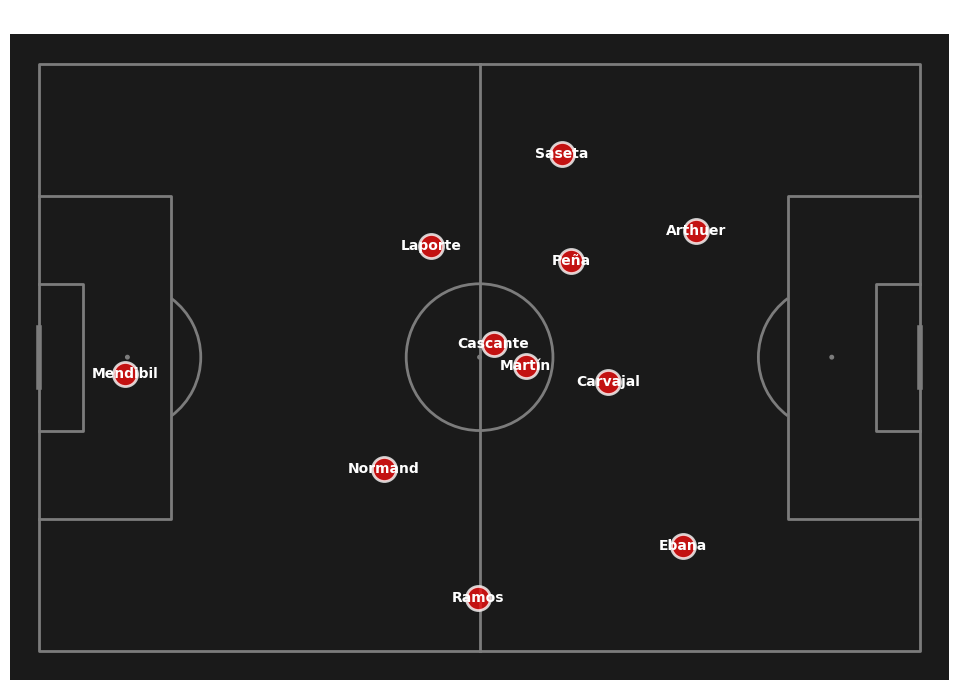

In [2]:
# 1. Filter for Starting XI and Events before the first substitution
# To get a clear tactical shape, we'll look at the first 45 minutes
starting_xi_spain = events[(events.team == 'Spain') & (events.type == 'Pass') & (events.minute < 45)]

# 2. Calculate average x and y coordinates for each player
avg_locs = starting_xi_spain.groupby('player').agg({'location_x': ['mean'], 'location_y': ['mean']})
avg_locs.columns = ['x', 'y']

# 3. Setup the Pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#1a1a1a', line_color='#7c7c7c')
fig, ax = pitch.draw(figsize=(10, 7))

# 4. Plot the average positions as points
pitch.scatter(avg_locs.x, avg_locs.y, s=300, color='#ef1010', edgecolors='white', linewidth=2, alpha=0.8, ax=ax)

# 5. Add Player Names to the points
for i, row in avg_locs.iterrows():
    # We split the name to show only the last name for clarity
    short_name = i.split(' ')[-1]
    pitch.annotate(short_name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=10, weight='bold', ax=ax)

plt.title("Spain's Tactical Setup (Average Positions - 1st Half)", color='white', size=15)
plt.savefig('images/spain_avg_positions.png') # Saving to our project images folder
plt.show()

## Phase 3: Passing Network Analysis
The **Passing Network** is the ultimate tactical visualization. It combines:
1. **Average Positions:** Where players were located on average.
2. **Communication Lines:** The thickness of the lines between players represents the volume of passes exchanged.
3. **Tactical Nodes:** Larger circles indicate players who were more involved in the team's build-up.

This helps us identify the "Playmakers" and the most frequent passing combinations.

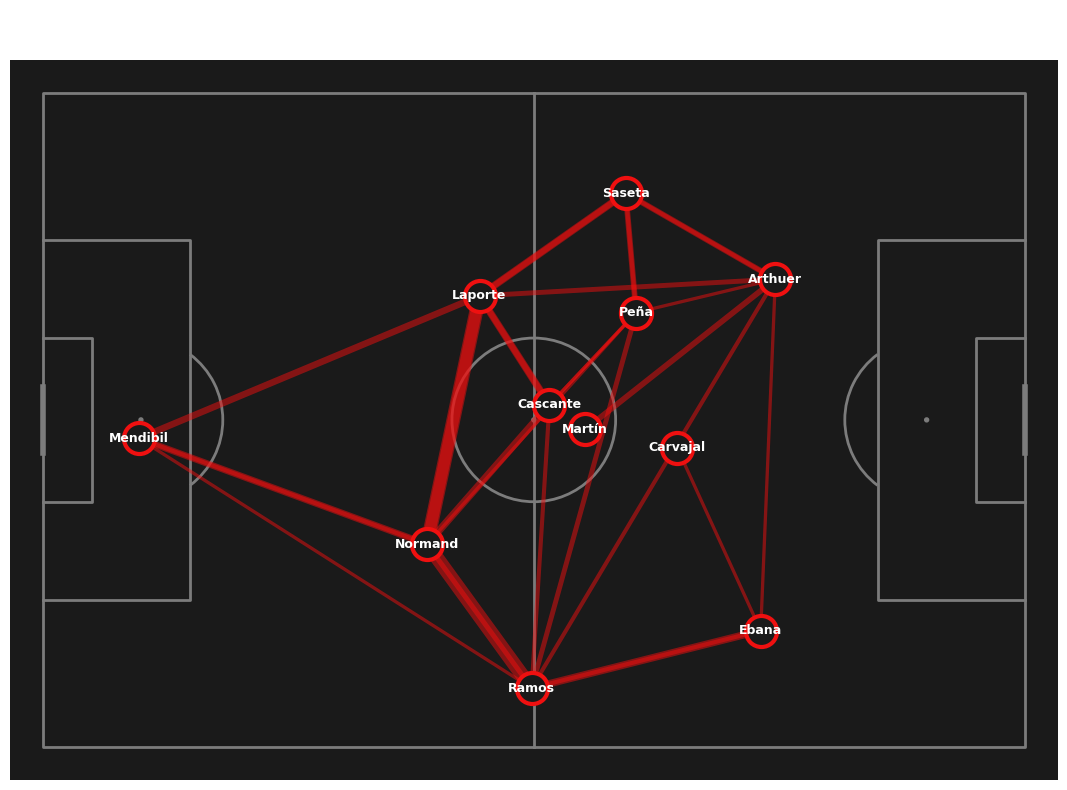

In [3]:
import pandas as pd
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# 1. Prepare the data for Spain (First Half to avoid substitution noise)
spain_passes = events[(events.team == 'Spain') & (events.type == 'Pass') & (events.minute < 45)].copy()

# 2. Calculate average positions and pass counts between players
# We need to find the sender and the receiver for each pass
passes_between = spain_passes.groupby(['player', 'pass_recipient']).id.count().reset_index()
passes_between.rename(columns={'id': 'pass_count'}, inplace=True)

# 3. Get average locations for each player
avg_locs = spain_passes.groupby('player').agg({'location_x': ['mean'], 'location_y': ['mean']})
avg_locs.columns = ['x', 'y']

# 4. Filter for strong connections (e.g., more than 3 passes) to keep the chart clean
passes_between = passes_between.merge(avg_locs, left_on='player', right_index=True)
passes_between = passes_between.merge(avg_locs, left_on='pass_recipient', right_index=True, suffixes=('', '_end'))
passes_between = passes_between[passes_between.pass_count > 3]

# 5. Plotting the Network
pitch = Pitch(pitch_type='statsbomb', pitch_color='#1a1a1a', line_color='#7c7c7c')
fig, ax = pitch.draw(figsize=(12, 8))

# Draw the lines (edges) between players
weights = passes_between.pass_count / passes_between.pass_count.max() * 10
pitch.lines(passes_between.x, passes_between.y, passes_between.x_end, passes_between.y_end,
            lw=weights, color='#ef1010', alpha=0.5, zorder=1, ax=ax)

# Draw the player nodes
pitch.scatter(avg_locs.x, avg_locs.y, s=500, color='#1a1a1a', edgecolors='#ef1010', 
              linewidth=3, alpha=1, zorder=2, ax=ax)

# Add Player Names (Shortened)
for i, row in avg_locs.iterrows():
    short_name = i.split(' ')[-1]
    pitch.annotate(short_name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=9, weight='bold', zorder=3, ax=ax)

plt.title("Spain's Passing Network - Euro 2024 Final", color='white', size=20, pad=20)
plt.savefig('images/spain_passing_network.png', bbox_inches='tight') #
plt.show()